# Importing Modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

# Data Set

In this project we will apply principal component analysis and clustering techniques on the UsArrests dataset from the US Arrests Kaggle challenge. The dataset contains information on the state and the percentage of the population that lives in the urban areas in the state (UrbanPop). The data set also contains information on the statistics on Murder, Assault and Rape arrests per state.

In [2]:
# loading data into dataframe
arrests_df = pd.read_csv('UsArrests.csv')

arrests_df.head() # first five rows

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


The City column has to be renamed to be the State column as calling the column that contains names of states 'City' is misleading.

In [3]:
# renaming the City column to State
arrests_df.rename(columns = {'City':'State'}, inplace = True)

arrests_df.tail() # last five rows

,State,Murder,Assault,UrbanPop,Rape
45,Virginia,8.5,156,63,20.7
46,Washington,4.0,145,73,26.2
47,West Virginia,5.7,81,39,9.3
48,Wisconsin,2.6,53,66,10.8
49,Wyoming,6.8,161,60,15.6


In [4]:
# dimensions of the dataframe
arrests_df.shape 

(50, 5)

In [5]:
arrests_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


The dataset has 50 rows and 5 columns, the next step is to determine if the dataset contains any null values. Missing data can be handled by removing the rows with the missing values, but that would result in the exclusion of information depending on the extent of the missing data. Imputation is the best way to handle the missing data, since it helps with retaining the collected information.

Missing data points can be handled using different types of imputation such as imputing the average, mode, median etc, and using some machine learning techniques.

In [6]:
# getting the number of missing data points per column
missing_datapoints = arrests_df.isnull().sum()

# number of missing data points in the columns
missing = pd.DataFrame(missing_datapoints, columns = ['Missing Values'])

missing

,Missing Values
State,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


Fortunately for this dataset there are no missing data points and therefore there is not requirement for missing data handling. the next step is to explore the dataset and see what we can learn from it.

# Data Exploration

The statistics describing the collected data can be seen in the figure below.

In [7]:
# statistics of the data set
data_stats = arrests_df.describe()

data_stats # displaying stats

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


From the statistical data above we can see that Assault has significantly high values for the min, max , std and mean. This indicates that the data will need scaling as this feature would predominantly affect the analysis of the machine learning. The same can be said for UrbanPop.

The distribution of each of the features of the datasets can be seen in the figure below.

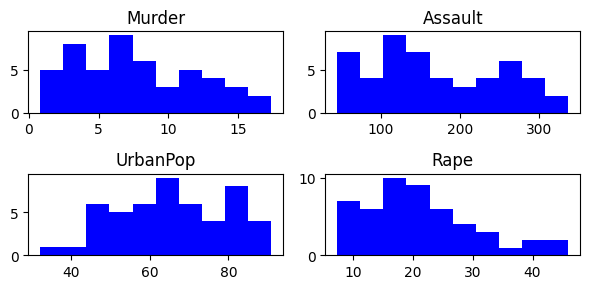

In [8]:
# Plot histograms
histograms = arrests_df.hist(color='blue', grid = False, figsize=(6, 3))
plt.tight_layout()
plt.show()

The data can best be summarised by the information in the table below. This table tells us about the mean, minimum, maximum and standard deviation of each feature.

In [9]:
data_stats = data_stats.loc[["mean","std","min","max"]].transpose() #select relevant rows

missing_datapoints = missing_datapoints[1:]

# Create summary table
frames = [missing_datapoints,data_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary

,missing,mean,std,min,max
Murder,0,7.788,4.355510,0.8,17.4
Assault,0,170.760,83.337661,45.0,337.0
UrbanPop,0,65.540,14.474763,32.0,91.0
Rape,0,21.232,9.366385,7.3,46.0


Looking at the above table, we can notice once more that the assault row contains large numbers in comparison to the other features and therefore scaling will be necessary for this data set. 

# Correlation Analysis

From the plot below all the variables are positively correlated with some variables with weak correlation and some with strong correlation. The correlation coefficient can give insight of the linear relationship of two variables, negative correlation meaning one variable increases as the other decreases, correlation of zero meaning no linear relationship between variables and positive correlation meaning there is an increasing relationship between the variables.

The correlation plot below shows that assault is strongly correlated with murder, this makes sense as violence can usually lead to someone dying.

In [10]:
state = arrests_df.State # storing states data

# correlation coefficient matrix
corr_df = arrests_df.drop(["State"],axis=1).corr()
labels =corr_df.columns

correlations = corr_df.corr()

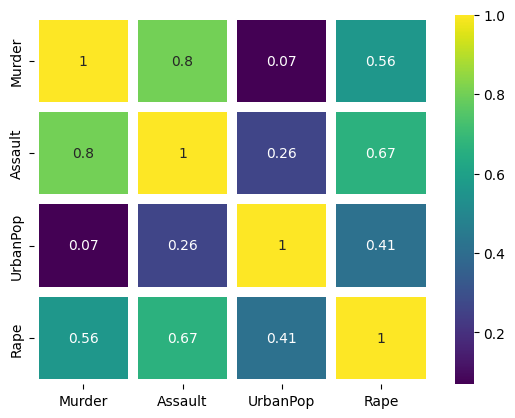

In [11]:
# heatmap of correlation coefficient
sns.heatmap(corr_df, cmap = 'viridis', annot = True, linewidth = 6);

In contrast the correlation between murder and rape is not as strong, this may be due to the fact that rape occurs in many different levels of society with different levels of violence involved, and this may show that most people are not killed during the incident but may just be intimidated into silence and fear is used to keep them silent so that this act may occur multiple times without reporting it. 

The correlation plot also suggests that living in a more urban area you are likely to be assaulted and more likely to be a victim of rape, but least likely to be a victim of murder as the correlation coefficient is close to zero. But this coefficient does suggest that it is rare but does still occur.


# Principal Component Analysis

Principal component analysis is a technique that is used to reduce the dimensionality of a data set. This helps with removing redundancies in the data set by looking for principal components and thus optimise the learning of the machine learning algorithm.

## Unstandardised Data

As stated before, this data set requires scaling before the principal component analysis is conducted. The biplot below is to demonstrate the effects of un-scaling the data on our analysis.

The biplot function is borrowed from the L3T12_example_plots notebook and reused for the purpose of this analysis, I did not write it myself but made moinor changes to it to meet the objectives of this project.

In [12]:
# PCA object
pca = PCA() 

# data without feature scaling
X = arrests_df.drop(["State"],axis=1).values

# PCA on unscaled data
X_trans = pca.fit_transform(X)

# PCA dataframe
df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802164,11.448007,-2.494933,2.407901
1,92.827450,17.982943,20.126575,-4.094047
2,124.068216,-8.830403,-1.687448,-4.353685
3,18.340035,16.703911,0.210189,-0.520994
4,107.422953,-22.520070,6.745873,-2.811826


In [13]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = state[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
            
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

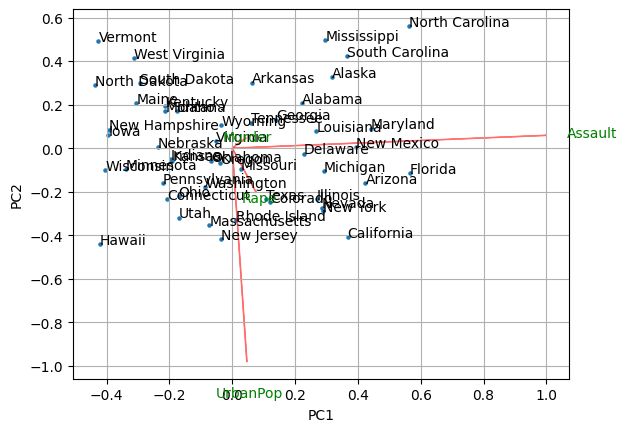

In [14]:
# plotting the biplot
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(state))
plt.show()

The biplot above indicates the importance of each feature by the length of its arrow (red) as seen in the biplot above, this arrow corresponds to the magnitude values of the eigenvectors. From the above plot we can see that Assault and UrbanPop are the two most important features as the arrows dominate the biplot.

The table below summarises the importance of these features and we can see that Assault has the highest and entirely dominates importance on the first principal component, while the same is true for UrbarnPop on the second principal component.

In [15]:
# getting the first and second principal components
pc1 = abs( pca.components_[0] )
pc2 = abs( pca.components_[1] )

# creating dataframe of features and PCA importance of features
Feature_PCA_df = pd.DataFrame()

# populating rows and columns of dataframe
Feature_PCA_df["Features"] = list(labels)
Feature_PCA_df["PC1 Importance"] = pc1
Feature_PCA_df["PC2 Importance"] = pc2

# displaying results
Feature_PCA_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.041704,0.044822
1,Assault,0.995221,0.058760
2,UrbanPop,0.046336,0.976857
3,Rape,0.075156,0.200718


## Standardised Data

The feature scaling of the data has been performed using the sklearn StandardScaler. The biplot below demonstrates the effects of scaling the data on our analysis.

In [16]:
# standardised data
X_std = StandardScaler().fit_transform(X)

# pca object
std_pca = PCA() 

# principal component analysis on standardised data
X_std_trans = std_pca.fit_transform(X_std)

# dataframe of PCA
df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.985566,1.133392,-0.444269,0.156267
1,1.950138,1.073213,2.040003,-0.438583
2,1.763164,-0.745957,0.054781,-0.834653
3,-0.141420,1.119797,0.114574,-0.182811
4,2.523980,-1.542934,0.598557,-0.341996


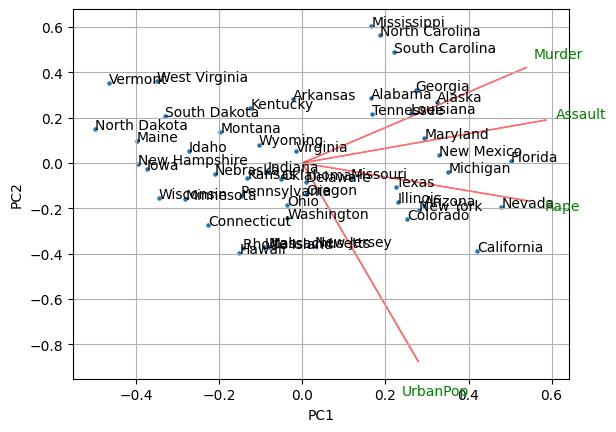

In [17]:
# plotting the biplot
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

The biplot above shows that scaling reduces the effects of large scale data dominating the principal component analysis.  It  can be noted that states like Nevada, Arizona and New York are dominated by rape, while states such as Maryland, New Mexico and Florida are dominated by assault and states such as Alaska, Georgia and Louisiana are dominated by murder.

The importance of the features is summarised in the table below. Assault still has higher importance on the first principal component but Murder and Rape are not that far off, while on the second principal component UrbanPop is still dominating. This makes sense as the UrbanPop is least correlated with the other features.

In [18]:
# getting the first and second principal components
pc1 = abs( std_pca.components_[0] ) 
pc2 = abs( std_pca.components_[1] )

# creating dataframe of features and PCA importance of features
feat_df = pd.DataFrame()

# populating rows and columns of dataframe
Feature_PCA_df["Features"] = list(labels)
Feature_PCA_df["PC1 Importance"] = pc1
Feature_PCA_df["PC2 Importance"] = pc2

# displaying results
Feature_PCA_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.535899,0.418181
1,Assault,0.583184,0.187986
2,UrbanPop,0.278191,0.872806
3,Rape,0.543432,0.167319


Principal component analysis is useful in reducing the dimensionality of the data set, and thus when using this technique it is important to choose the appropriate number of principal components that explain most of the variance in the data set. 

This can be achieved by using the Scree plot and Cumulative Explained Variance plot. These plots can be seen below.

## Scree and Cumulative Explained Variance Plots

The code used to generate these plots is borrowed from the L3T12_example_plots notebook.

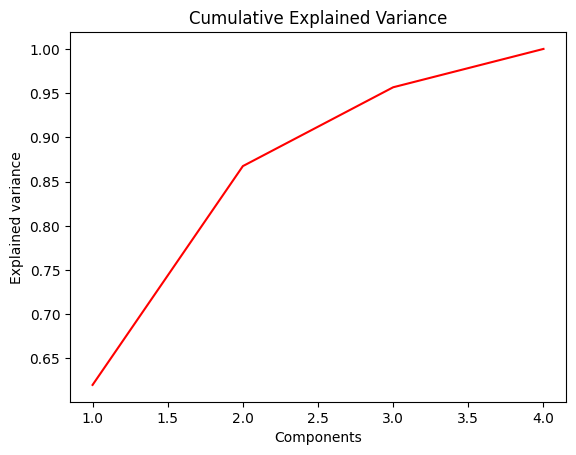

In [19]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")
plt.show()

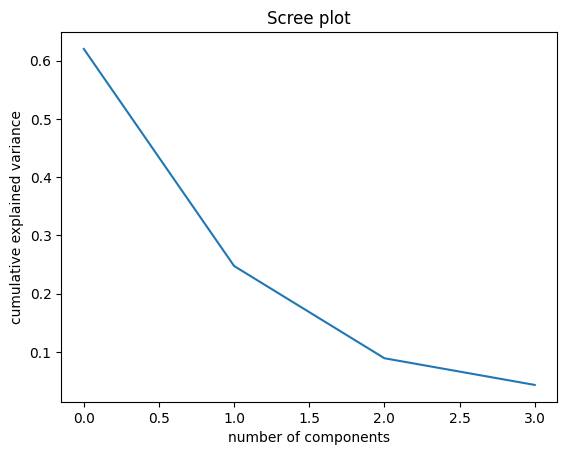

In [20]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first 3 principal components together explain around at least 95% of the variance, therefore we can use them to perform cluster analysis. The dimensions of the data set can be reduced from 4 to 3.

# Clustering

For the clustering we will look at two clustering techniques, namely k-means and hierarchical clustering. First we will look at k-means clustering as seen below. The code used to generate these plots is borrowed from the L3T12_example_plots notebook with a few changes to meet the objectives of this task.

In [21]:
# storing the first 3 principal components into a dataframe
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = state)
pca_df.head()

,0,1,2
State,,,
Alabama,0.985566,1.133392,-0.444269
Alaska,1.950138,1.073213,2.040003
Arizona,1.763164,-0.745957,0.054781
Arkansas,-0.141420,1.119797,0.114574
California,2.523980,-1.542934,0.598557


## K-Means Clustering

K-means clustering is a simple unsupervised machine learning algorithm that is used to group together similar data points of a data set and find underlying patterns using a fixed number of specified clusters popularly denoted as k. 

For our analysis the chosen value of k is 4 meaning we are looking to group the data into 4 clusters. A visualisation of the clusters can be seen in the figure below.

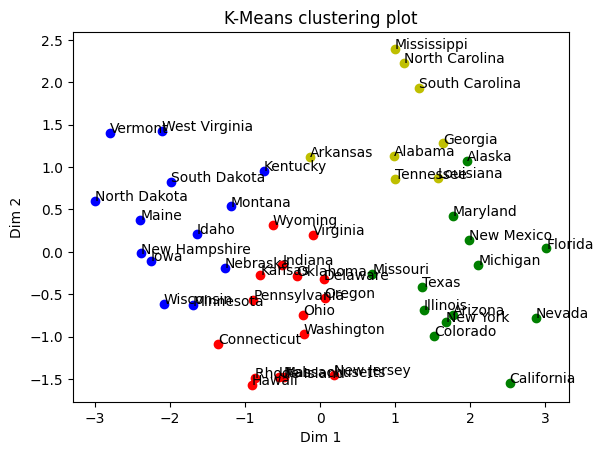

In [22]:
# Extracting the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k = 4

# k-means clustering model
kmeans = KMeans(n_clusters = k, init = 'k-means++')
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'

for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        text = state[i]
        ax.annotate(text, (x[i], y[i]))
        
ax.set_title("K-Means clustering plot")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
plt.show()

It seems the k-means algorithm has clustered together these states based on the severity of the crimes or magnitudes of the numbers on each of the features. States with large numbers are mostly clustered together and those with the least numbers are clustered together. States with the blue dots have the least numbers in arrest for these crimes while states in red dots have the highest numbers in at least two features (crime categories).

## Hierarchical clustering

The dendrogram plot can be used to visualise the clusters of the hierarchical clustering algorithm before the algorithm is run, this is possible as a dendrogram does not require a specification of the number clusters and can be used to decide the number of clusters after running the hierarchical clustering algorithm. 

The linkage method to be used to measure the distance between clusters is  determined by plotting and comparing different dendrograms for single, complete and average. The distance metric used is the Euclidean. 

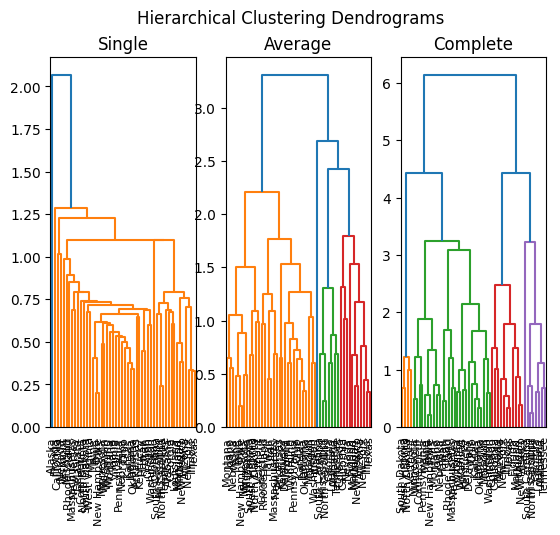

In [23]:
# subplotting dendrograms for 3 methods (single, average and complete)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrograms')

# single method dendrogram
ax1.set_title("Single")
dendrogram(linkage(pca_df, method = 'single'), labels = pca_df.index, ax = ax1)

# average method dendrogram
ax2.set_title("Average")
dendrogram(linkage(pca_df, method = 'average'), labels = pca_df.index, ax = ax2)

# complete method dendrogram
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method = 'complete'), labels = pca_df.index, ax = ax3)


plt.show() # displaying dendrograms

The complete linkage method is the method of choice to use as it  creates the most balanced spread of clusters. The dendrogram using this method can be seen in the figure below, this is to isolate the dendrogram for clear visualisation.

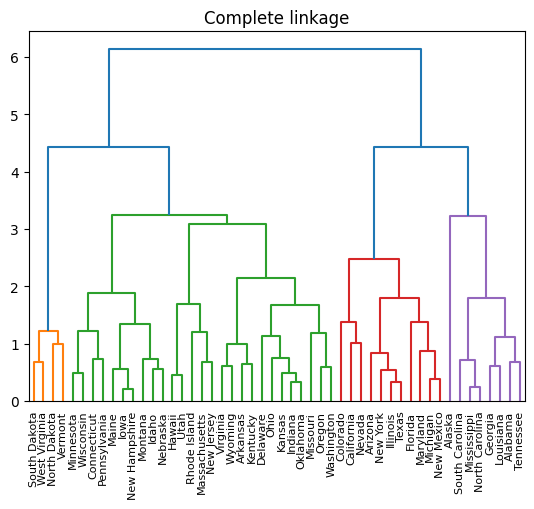

In [24]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method = 'complete'), labels = pca_df.index)
plt.show()

From the dendrogram above we can see that there are four clusters of sizes 4,  27, 11 and 8.  The clustering numbers are not far off from those gotten from the k-means algorithm and some states are clustered similarly in both cases. The clustering is done based on the severity of the crime arrests in the states.

The states with the least numbers in crime arrests are in orange, followed by the ones in green, then the ones in red and the states with the highest numbers in crime arrests clustered together in blue.
 

## 